<a href="https://colab.research.google.com/github/Sinusoid42/augmentation_jupyter/blob/main/Data_augmentation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization of the Notebook

<h1>Data Augmentation Juypiter Notebook</h1>
<br>
This Notebook creates new Data for the Dataaugmentation to create rejectable Data


<h3>Mount the Colab Drive</h3>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab_Drive/BV_BBH/Basisdaten/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/13lAsfVwJ_spUiyhXwS2sjsbGAOclb9hQ/Basisdaten


<h1>Imports</h1>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import ipywidgets as widgets

# Retrieve GT Images

In [ ]:
%cd /content/drive/MyDrive/Colab_Drive/BV_BBH/Basisdaten/TestImages
path = "GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00043"
all_imgs = {}
with open('gt.txt','r') as f:

    print('Parsing annotation files')

    for line in f:
      line_split = line.strip().split(';')
      (filename,x1,y1,x2,y2,class_name)=line_split

      all_imgs[filename] = {}
      all_imgs[filename]['filepath'] = filename
      all_imgs[filename]['bboxes'] = []
      all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})

/content/drive/.shortcut-targets-by-id/13lAsfVwJ_spUiyhXwS2sjsbGAOclb9hQ/Basisdaten/TestImages
Parsing annotation files


# Utility Functions

Store an augmentated Image as PPM File

In [ ]:
def save_as_ppm_file(img, width, height, maxval, name, path):
  # PPM header
  ppm_header = f'P6 {width} {height} {maxval}\n'

  %cd /content/drive/My Drive/Colab_Drive/BV_BBH/Basisdaten/$path
  # Save the PPM image as a binary file
  with open(name + '.ppm', 'wb') as f:
    f.write(bytearray(ppm_header, 'ascii'))
    img.tofile(f)

Batch store rejection images at base location + path


In [ ]:
def batch_save_ppm_files(images, path):
  %cd /content/drive/My Drive/Colab_Drive/BV_BBH/Basisdaten/
  index = 0
  for img in images:
    img = np.array(img)
    width, height, channel = img.shape
    save_as_ppm_file(img, width, height, 255, str(index), path)
    index += 1

# Mathematical Necessity implementations

The following section implements mathematical functionalities to apply
mathematical constructs to be applied to create data augmentated images


<h1>Matrix Class Definition</h1>

Matrix Class implementation to create 3x3 matricies to be able to apply rotations, transformations and scalation

In [ ]:
class mat:
  def __init__(self, m00 = 1.0, m10 = 0.0, m20 = 0.0, m01 = 0.0, m11 = 1.0, m21 = 0.0, m02 = 0.0, m12 = 0.0, m22 = 1.0):
    self.m00 = m00
    self.m10 = m10
    self.m20 = m20

    self.m01 = m01
    self.m11 = m11
    self.m21 = m21

    self.m02 = m02
    self.m12 = m12
    self.m22 = m22

  ###vector matrix multiplication with 3 scalar values
  ###returns 3 values x, y, z as a set of 3 scalar values
  def mulV3(self, x = 0.0, y = 0.0, z = 0.0):
    x0 = x * self.m00 + y*self.m01 + z * self.m02
    y0 = x * self.m10 + y*self.m11 + z * self.m12
    z0 = x * self.m20 + y*self.m21 + z * self.m22
    return x0, y0,z0  

  ###Cramers rule implementation to invert @self
  def inverse(self):
    tmp = mat(self.m00, self.m10, self.m20, self.m01, self.m11, self.m21, self.m02, self.m12, self.m22)

    self.m00 = tmp.m11 * tmp.m22 - tmp.m21 * tmp.m12
    self.m01 = tmp.m21 * tmp.m02 - tmp.m01 * tmp.m22
    self.m02 = tmp.m01 * tmp.m12 - tmp.m11 * tmp.m02
    self.m10 = tmp.m20 * tmp.m12 - tmp.m10 * tmp.m22 
    self.m11 = tmp.m00 * tmp.m22 - tmp.m20 * tmp.m02
    self.m12 = tmp.m10 * tmp.m02 - tmp.m00 * tmp.m12
    self.m20 = tmp.m10 * tmp.m21 - tmp.m20 * tmp.m11
    self.m21 = tmp.m20 * tmp.m01 - tmp.m00 * tmp.m21
    self.m22 = tmp.m00 * tmp.m11 - tmp.m10 * tmp.m01
    ###compute the determinante
    det = tmp.m00*tmp.m11*tmp.m22+tmp.m10*tmp.m21*tmp.m02+tmp.m20*tmp.m01*tmp.m12-tmp.m20*tmp.m11*tmp.m02-tmp.m10*tmp.m01*tmp.m22-tmp.m00*tmp.m21*tmp.m12
    if det==0 :
      self.put(tmp)
    else:
      self.mul(1/det)
    return self

  ###matrix multiplication with a scalar
  def mul(self, f = 1.0):
    self.m00 *= f
    self.m10 *= f
    self.m20 *= f

    self.m01 *= f
    self.m11 *= f
    self.m21 *= f
    
    self.m02 *= f
    self.m12 *= f
    self.m22 *= f
    return self

  ###matrix put method to store the values of one matrix in another
  def put(self, m):
    self.m00 = m.m00
    self.m01 = m.m01
    self.m02 = m.m02

    self.m10 = m.m10
    self.m11 = m.m11
    self.m12 = m.m12

    self.m20 = m.m20
    self.m21 = m.m21
    self.m22 = m.m22
    return self

  ###multiply a right matrix with this matrix
  def matmul(self, right):
    result = mat()
    result.m00 = self.m00 * right.m00 + self.m01 * right.m10 + self.m02 * right.m20
    result.m01 = self.m00 * right.m01 + self.m01 * right.m11 + self.m02 * right.m21
    result.m02 = self.m00 * right.m02 + self.m01 * right.m12 + self.m02 * right.m22

    result.m10 = self.m10 * right.m00 + self.m11 * right.m10 + self.m12 * right.m20
    result.m11 = self.m10 * right.m01 + self.m11 * right.m11 + self.m12 * right.m21
    result.m12 = self.m10 * right.m02 + self.m11 * right.m12 + self.m12 * right.m22

    result.m20 = self.m20 * right.m00 + self.m21 * right.m10 + self.m22 * right.m20
    result.m21 = self.m20 * right.m01 + self.m21 * right.m11 + self.m22 * right.m21
    result.m22 = self.m20 * right.m02 + self.m21 * right.m12 + self.m22 * right.m22

    return result

  ###print(mat) function
  def __str__(self):
    return "[" + str(self.m00) + ", " + str(self.m01) + ", " + str(self.m02) + "]\n"+ "[" + str(self.m10) + ", " + str(self.m11) + ", " + str(self.m12) + "]\n" + "[" + str(self.m20) + ", " + str(self.m21) + ", " + str(self.m22)+ "]"

Utility Function to create a transformation matrix for augmentating input images


In [ ]:
def compute_inverse_transformation_matrix(result_image_size = 50,xscale = 1, yscale = 1, angle=0, x1=0, y1=0, x2=0, y2=0):
 
  centerx = -((x2-x1)/2.0+x1)
  centery = -((y2-y1)/2.0+y1)

  fx = result_image_size/( x2-x1 ) * xscale
  fy = result_image_size/( y2-y1 ) * yscale

  m00 = math.cos(angle)
  m01 = -math.sin(angle)
  m10 = math.sin(angle)
  m11 = math.cos(angle)

  t = mat(1.0,0.0,0.0,0.0,1.0,0.0,centerx, centery, 1.0)
  s = mat(fx,0.0,0.0,0.0,fy,0.0,0.0,0.0,1.0)
  r = mat(m00,m10,0.0,m01,m11,0.0,0.0,0.0,1.0)
  
  ts = s.matmul(t)
  return r.matmul(ts).inverse()

# Data augmentation function

In [ ]:
def generate_rotated_rejection_data(image_size = 50, angle_min = 0, angle_max = 0, xsmin = 1, xsmax = 1, ysmin = 1, ysmax = 1 , xmin = 0, xmax = 0, ymin = 0, ymax = 0, size = 5):
  %cd /content/drive/My Drive/Colab_Drive/BV_BBH/Basisdaten/TestImages
  rejection_imgs = []
  index = 0
  im_names = [i for i in all_imgs]
  nbr_of_imgs = len(all_imgs)

  ###create 'size' amount of rejection images, run over all images available from all images
  while(index<size):

    ##randomly select an image from all images available and perform augmentation for that image
    p = random.randint(0, len(all_imgs)-1)

    #retrieve the bounding box for the traffic sign within that image
    bbox = all_imgs[im_names[p]]["bboxes"][0]
    
    #create a random angle inbetween the bounds of angle min and angle max
    a = random.randint(angle_min, angle_max)
    
    ###compute the angle from degrees to 
    Angle = 2*3.14159267*a/360.0

    #affects of scalation
    xS = random.random()*(xsmax - xsmin) + xsmin
    yS = random.random()*(ysmax - ysmin) + ysmin
    
    #compute the inverse transformation matrix for the parameters given
    tmp = compute_inverse_transformation_matrix(image_size, angle = Angle, xscale = xS, yscale = yS, x1 = bbox["x1"],y1 = bbox["y1"], x2 = bbox["x2"],y2 = bbox["y2"])
    
    #create a new array for the pixeldata
    im = []*image_size

    #get the image
    the_image = cv2.imread(all_imgs[im_names[p]]['filepath'])
    
    #compute the offset for the images
    '''
      If xmin, xmax are 0 both, the image center will not be shifted, else the center will be shifted by the range of [xmin, xmax] randomly
    '''
    xoffset = random.randint(xmin,xmax)
    yoffset = random.randint(ymin,ymax)

    #randomly set the offset to be negative or positive
    if random.randint(1,2) == 1:
      xoffset*=1;
    if random.randint(1,2) == 1:
      yoffset*=1;

    #run of ver the imagepixels
    for i in range(image_size):

      k = []
      for j in range(image_size):
        x,y,z = tmp.mulV3(j-image_size/2,i-image_size/2,1) #50/2 offset
        x = int(x)
        y = int(y)

        x+= xoffset;
        y+= yoffset;

        #clamping
        if y<0:
          y=0
        if y>=len(the_image):
          y = len(the_image)-1
        if x<0:
          x=0
        if x>=len(the_image[0]):
          x = len(the_image)-1
        #appending
        k.append(the_image[y][x])
      #appending
      im.append(k)
    
    rejection_imgs.append(im)
    index = index+1     

  return rejection_imgs

# Augmentation Configuration




In [ ]:
class Config():
  def __init__(self):
    result_image_size = 50 #@param {type:"integer"}

    number_of_images =  2400#@param {type:"integer"}
  
    x_scale_min = 1.0 #@param {type:"number"}
    y_scale_min = 1.0 #@param {type:"number"}

    x_scale_max = 1.0 #@param {type:"number"}
    y_scale_max = 1.0 #@param {type:"number"}

    x_shift_min = 33   #@param {type:"integer"}
    y_shift_min = 33   #@param {type:"integer"}

    x_shift_max =    250#@param {type:"integer"}
    y_shift_max = 250   #@param {type:"integer"}

    angle_min = 0 #@param {type:"slider", min:0, max:359, step:1}
    angle_max = 20 #@param {type:"slider", min:0, max:360, step:1}


    self.number_of_images = number_of_images
    self.result_image_size = result_image_size
    self.x_scale_min = x_scale_min
    self.y_scale_min = y_scale_min
    self.x_scale_max = x_scale_max
    self.y_scale_max = y_scale_max

    self.x_shift_min = x_shift_min
    self.y_shift_min = y_shift_min
    self.x_shift_max = x_shift_max
    self.y_shift_max = y_shift_max

    self.angle_min = angle_min
    self.angle_max = angle_max

    path0 = "GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/" 
    rejection_image_directory = "rejection_images" #@param {type:"string"}

    self.path = path0 + rejection_image_directory


# Run the Augmentation

In [ ]:
config = Config()
%cd /content/drive/My Drive/Colab_Drive/BV_BBH/Basisdaten/
images = generate_rotated_rejection_data(
    image_size = config.result_image_size, 
    angle_min = config.angle_min, 
    angle_max = config.angle_max, 
    xsmin=config.x_scale_min, 
    xsmax = config.x_scale_max, 
    ysmin=config.y_scale_min, 
    ysmax =config.y_scale_max, 
    xmin = config.x_shift_min, 
    xmax = config.x_shift_max, 
    ymin = config.y_shift_min, 
    ymax = config.y_shift_max, 
    size = config.number_of_images)
batch_save_ppm_files(images, config.path)

/content/drive/.shortcut-targets-by-id/13lAsfVwJ_spUiyhXwS2sjsbGAOclb9hQ/Basisdaten
/content/drive/.shortcut-targets-by-id/13lAsfVwJ_spUiyhXwS2sjsbGAOclb9hQ/Basisdaten/TestImages
/content/drive/.shortcut-targets-by-id/13lAsfVwJ_spUiyhXwS2sjsbGAOclb9hQ/Basisdaten
/content/drive/.shortcut-targets-by-id/13lAsfVwJ_spUiyhXwS2sjsbGAOclb9hQ/Basisdaten/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/rejection_images
/content/drive/.shortcut-targets-by-id/13lAsfVwJ_spUiyhXwS2sjsbGAOclb9hQ/Basisdaten/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/rejection_images
/content/drive/.shortcut-targets-by-id/13lAsfVwJ_spUiyhXwS2sjsbGAOclb9hQ/Basisdaten/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/rejection_images
/content/drive/.shortcut-targets-by-id/13lAsfVwJ_spUiyhXwS2sjsbGAOclb9hQ/Basisdaten/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/rejection_images
/content/drive/.shortcut-targets-by-id/13lAsfVwJ_spUiyhXwS2sjsbGAOclb9hQ/Basisdaten/GTSRB_Final_Training_Imag

Show a testimage

[[[array([246, 238, 232], dtype=uint8), array([245, 235, 230], dtype=uint8), array([254, 241, 234], dtype=uint8), array([251, 242, 234], dtype=uint8), array([247, 238, 227], dtype=uint8), array([250, 243, 226], dtype=uint8), array([250, 239, 229], dtype=uint8), array([249, 240, 232], dtype=uint8), array([249, 242, 234], dtype=uint8), array([249, 241, 236], dtype=uint8), array([251, 239, 234], dtype=uint8), array([249, 244, 234], dtype=uint8), array([255, 246, 239], dtype=uint8), array([252, 242, 235], dtype=uint8), array([255, 242, 240], dtype=uint8), array([249, 237, 229], dtype=uint8), array([249, 241, 230], dtype=uint8), array([248, 239, 229], dtype=uint8), array([179, 195, 210], dtype=uint8), array([ 71,  80, 105], dtype=uint8), array([14, 16, 45], dtype=uint8), array([15, 15, 46], dtype=uint8), array([15, 15, 47], dtype=uint8), array([15, 15, 47], dtype=uint8), array([27, 25, 45], dtype=uint8), array([51, 46, 54], dtype=uint8), array([89, 87, 83], dtype=uint8), array([88, 84, 80],

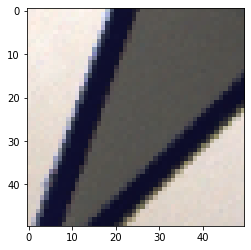

In [ ]:
print(images)
plt.imshow(images[0])
plt.show()